# Same as cat_price_predict scratchwork, using Alpaca API instead of FMP API.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import requests

%matplotlib inline

In [2]:
 # Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [3]:
 # Set the ticker
cat_ticker = "CAT"

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 4
start_date = pd.Timestamp("2017-07-11", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-06-29", tz="America/New_York").isoformat()


cat_data = api.get_barset(
    cat_ticker,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000,
).df

cat_data.head()

CAT                                 
                             open    high     low   close   volume
2017-07-11 00:00:00-04:00  105.50  108.46  104.80  105.80  2086502
2017-07-12 00:00:00-04:00  106.48  109.52  106.43  106.50  2783543
2017-07-13 00:00:00-04:00  106.42  106.77  105.52  106.03  2453505
2017-07-14 00:00:00-04:00  106.08  106.88  105.60  106.32  2655182
2017-07-17 00:00:00-04:00  105.55  108.84  105.53  106.39  2123063

In [18]:
cat_data.tail()

CAT                                   
                             open    high       low   close   volume
2021-06-23 00:00:00-04:00  213.48  216.77  212.5800  213.79  2937114
2021-06-24 00:00:00-04:00  216.54  221.93  215.3300  219.27  6188718
2021-06-25 00:00:00-04:00  221.43  221.75  215.2700  216.33  4212062
2021-06-28 00:00:00-04:00  216.47  216.78  213.5615  216.27  2719238
2021-06-29 00:00:00-04:00  217.80  218.70  214.5900  215.12  3119426

In [4]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [19]:
# Define the window size
window_size = 100

# Set the index of the feature and target columns
feature_column = 3
target_column = 3

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(cat_data, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[105.8    106.5    106.03   106.32   106.39   105.41   107.81   105.66
  104.94   108.43   112.77   111.76   112.6    112.33   112.19   111.35
  113.07   113.56   114.32   114.7    114.42   114.34   111.4    112.87
  111.95   111.89   112.35   113.18   112.16   113.58   115.8    114.755
  113.     113.56   113.29   114.21   115.73   117.48   118.3    116.47
  115.17   115.95   116.     117.03   119.07   119.63   118.62   121.37
  123.79   122.81   122.92   122.86   124.4    122.4    124.54   124.51
  123.29   122.78   122.79   123.57   124.78   124.44   124.97   126.8599
  126.21   126.61   127.98   128.69   131.47   128.52   131.27   129.51
  131.33   130.42   136.91   136.82   136.94   136.49   136.49   134.5
  136.289  136.45   135.32   136.39   137.48   135.97   135.36   135.17
  136.53   136.22   132.81   136.36   136.11   135.59   137.6    136.68
  137.42   137.2    137.65   138.06   139.79   140.16   140.14   138.79
  140.37   141.52   143.86   142.39   142.04 

In [20]:
# Manually splitting the data (70% for test, remaining 30% for training)
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [21]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [22]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.17767015]
  [0.18659189]
  [0.18060158]
  [0.18429773]
  [0.18518991]
  [0.17269946]
  [0.2032883 ]
  [0.1758858 ]
  [0.16670915]
  [0.21119042]
  [0.26650523]
  [0.25363242]
  [0.26433852]
  [0.26089727]
  [0.25911292]
  [0.24840683]
  [0.27032883]
  [0.27657405]
  [0.28626051]
  [0.29110375]
  [0.28753505]
  [0.28651542]
  [0.2490441 ]
  [0.26777976]
  [0.25605404]
  [0.25528932]
  [0.26115218]
  [0.27173082]
  [0.25873056]
  [0.27682896]
  [0.30512363]
  [0.29180474]
  [0.26943666]
  [0.27657405]
  [0.27313281]
  [0.28485853]
  [0.30423146]
  [0.32653581]
  [0.336987  ]
  [0.31366301]
  [0.29709406]
  [0.30505255]
  [0.29983853]
  [0.31263197]
  [0.33797044]
  [0.3449261 ]
  [0.32878732]
  [0.36257525]
  [0.39230864]
  [0.38026785]
  [0.38161936]
  [0.37308942]
  [0.38246356]
  [0.35895628]
  [0.38410907]
  [0.38375646]
  [0.36941702]
  [0.36342266]
  [0.3635402 ]
  [0.35096846]
  [0.36436082]
  [0.36059768]
  [0.36646375]
  [0.38738129]
  [0.38018816]
  

In [23]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [24]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = window_size
# 20% of neurons to be dropped out
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [25]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200, 200)          161600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200, 200)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 200, 200)          320800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200, 200)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [26]:
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=100, verbose=1)

Epoch 1/20
6/6 [==============================] - 13s 1s/step - loss: 0.0337
Epoch 2/20
6/6 [==============================] - 11s 2s/step - loss: 0.0120
Epoch 3/20
6/6 [==============================] - 19s 3s/step - loss: 0.0041
Epoch 4/20
6/6 [==============================] - 31s 5s/step - loss: 0.0050
Epoch 5/20
6/6 [==============================] - 29s 5s/step - loss: 0.0032
Epoch 6/20
6/6 [==============================] - 30s 5s/step - loss: 0.0031
Epoch 7/20
6/6 [==============================] - 32s 5s/step - loss: 0.0030
Epoch 8/20
6/6 [==============================] - 33s 5s/step - loss: 0.0025
Epoch 9/20
6/6 [==============================] - 34s 6s/step - loss: 0.0026
Epoch 10/20
6/6 [==============================] - 37s 6s/step - loss: 0.0024
Epoch 11/20
6/6 [==============================] - 35s 6s/step - loss: 0.0023
Epoch 12/20
6/6 [==============================] - 31s 5s/step - loss: 0.0021
Epoch 13/20
6/6 [==============================] - 36s 6s/step - loss: 0.

In [27]:
model.evaluate(X_test, y_test, verbose=0)

0.009699714370071888

In [28]:
predicted = model.predict(X_test)

In [29]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(predicted)

In [30]:
cat_actual_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = cat_data.index[-len(real_prices): ]) 

# Show the DataFrame's head
cat_actual_predicted.head()

,Actual,Predicted
2020-07-17 00:00:00-04:00,129.829407,129.829407
2020-07-20 00:00:00-04:00,131.126450,131.126450
2020-07-21 00:00:00-04:00,132.311295,132.311295
2020-07-22 00:00:00-04:00,133.316315,133.316315
2020-07-23 00:00:00-04:00,134.142563,134.142563


In [31]:
cat_actual_predicted.tail()

,Actual,Predicted
2021-06-23 00:00:00-04:00,199.647781,199.647781
2021-06-24 00:00:00-04:00,197.699051,197.699051
2021-06-25 00:00:00-04:00,196.480682,196.480682
2021-06-28 00:00:00-04:00,195.886520,195.886520
2021-06-29 00:00:00-04:00,195.782608,195.782608


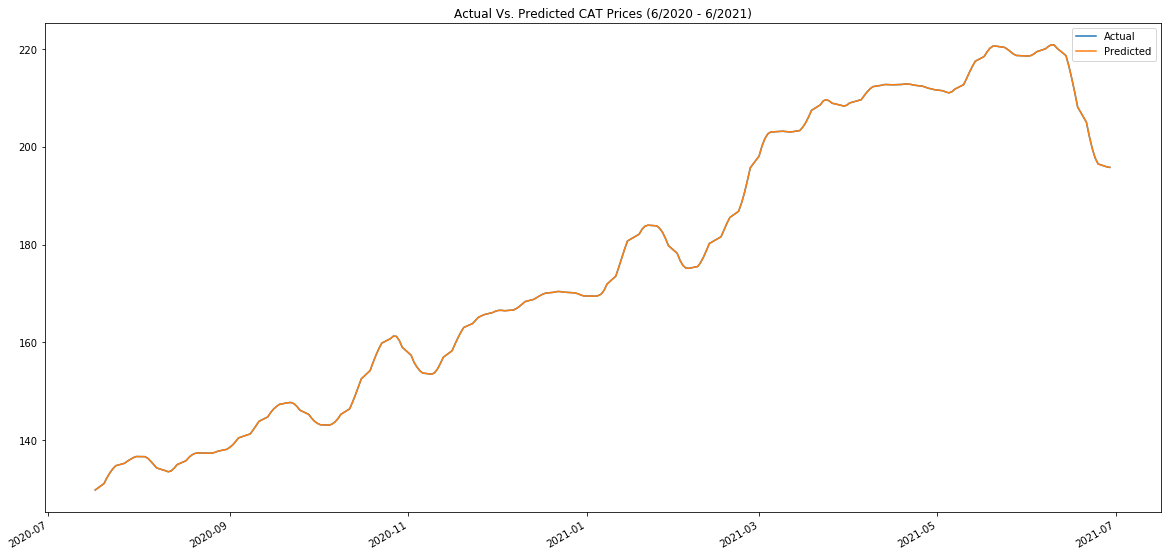

In [32]:
cat_actual_predicted.plot(title="Actual Vs. Predicted CAT Prices (6/2020 - 6/2021)", figsize=(20,10))